In [3]:
pip install pretty_midi soundfile

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import pretty_midi
from torch.utils.data import Dataset, DataLoader
import os
from os import walk
import matplotlib.pyplot as plt

In [5]:
# Constants
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
CHUNK_DURATION = 5  # seconds

In [6]:
from google.colab import drive
drive.mount('/content/drive')

device = "cudu" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [9]:
# Custom Dataset
class MusicDataset(Dataset):
    def __init__(self, midi_files, mp3_files):
        self.midi_files = midi_files
        self.mp3_files = mp3_files

    def __len__(self):
        return len(self.midi_files)

    def __getitem__(self, idx):
        midi_tensor = midi_to_tensor(self.midi_files[idx])
        mel_tensor = mp3_to_mel_tensor(self.mp3_files[idx])
        return midi_tensor, mel_tensor


In [35]:
# GRU Model
# class GRUSynthesizer(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers):
#         super(GRUSynthesizer, self).__init__()
#         self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.gru(x)
#         out = self.fc(out)
#         return out

class GRUSynthesizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, num_fc_layers=5):
        super(GRUSynthesizer, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Define additional fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        for _ in range(num_fc_layers - 1):
            self.fc_layers.append(nn.Linear(hidden_size, hidden_size))
        self.fc_layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        # GRU layer
        out, _ = self.gru(x)

        # Pass through fully connected layers
        for fc_layer in self.fc_layers:
            out = fc_layer(out)

        return out

In [27]:
def train_model(model, train_loader, num_epochs=10, learning_rate=0.001, graph=False):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store the training loss for graphing
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (midi_data, mel_data) in enumerate(train_loader):
            outputs = model(midi_data)
            outputs = outputs.transpose(1, 2)  # Transpose to match target shape

            loss = criterion(outputs, mel_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    print("Training complete!")

    if graph:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs+1), losses, marker='o')
        plt.title("Training Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()


In [28]:
# Save the trained model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [29]:
def load_model(path, input_size, hidden_size, output_size, num_layers):
    model = GRUSynthesizer(input_size, hidden_size, output_size, num_layers)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [55]:
  # Helper Functions
def midi_to_tensor(midi_file, duration=CHUNK_DURATION):
    """Convert a MIDI file to a tensor representation."""
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    # Create a piano roll with the shape (number of notes, time steps)
    piano_roll = midi_data.get_piano_roll(fs=SAMPLE_RATE // HOP_LENGTH)
    total_frames = piano_roll.shape[1]

    # Pad or truncate to match the required chunk duration
    target_frames = int(SAMPLE_RATE * duration / HOP_LENGTH)
    if total_frames < target_frames:
        padding = target_frames - total_frames
        piano_roll = np.pad(piano_roll, ((0, 0), (0, padding)), mode='constant')
    else:
        piano_roll = piano_roll[:, :target_frames]

    # Normalize and convert to tensor
    piano_roll = torch.tensor(piano_roll, dtype=torch.float32) / 128.0
    return piano_roll.T  # Transpose to (time steps, notes)

def mp3_to_mel_tensor(mp3_file, duration=CHUNK_DURATION):
    """Convert an MP3 file to a mel-spectrogram tensor."""
    y, sr = librosa.load(mp3_file, sr=SAMPLE_RATE)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or truncate to match the required chunk duration
    target_frames = int(SAMPLE_RATE * duration / HOP_LENGTH)
    if mel_spec.shape[1] < target_frames:
        padding = target_frames - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, padding)), mode='constant')
    else:
        mel_spec = mel_spec[:, :target_frames]

    return torch.tensor(mel_spec, dtype=torch.float32)

def mel_tensor_to_audio(mel_tensor, n_fft=2048, hop_length=512, win_length=None, n_iter=60):
    if win_length is None:
        win_length = n_fft  # Default win_length to n_fft if not provided

    mel_spec = mel_tensor.numpy()

    # Convert mel-spectrogram back to the linear scale
    mel_inverted = librosa.feature.inverse.mel_to_stft(mel_spec, sr=SAMPLE_RATE, n_fft=n_fft, power=2.0)

    # Apply the Griffin-Lim algorithm to estimate the phase
    audio_waveform = librosa.griffinlim(mel_inverted, n_iter=n_iter, hop_length=hop_length, win_length=win_length, window='hann')

    return audio_waveform

In [56]:
tensor = mp3_to_mel_tensor('/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MP3/Air_On_The_G_String_-_Johann_Sebastian_Bach.mp3', duration=20)
print(tensor.size())
Audio(mel_tensor_to_audio(tensor), rate=22050)
# Audio('/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MP3/Air_On_The_G_String_-_Johann_Sebastian_Bach.mp3')

torch.Size([128, 861])


In [31]:
# Complete Workflow Function
def run_workflow(midi_files, mp3_files, model_save_path, num_epochs=10, learning_rate=0.001, graph=False):
    # Dataset and DataLoader
    dataset = MusicDataset(midi_files, mp3_files)
    train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Model initialization
    input_size = dataset[0][0].shape[1]  # Number of notes (piano roll width)
    hidden_size = 128
    output_size = N_MELS  # Mel-spectrogram height
    num_layers = 2

    model = GRUSynthesizer(input_size, hidden_size, output_size, num_layers)

    # Train the model
    torch.manual_seed(14)
    train_model(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, graph=graph)

    # Save the model
    save_model(model, model_save_path)

In [32]:
import soundfile as sf

def generate_mp3_from_midi(model, midi_file, output_mp3_file):
    midi_tensor = midi_to_tensor(midi_file)

    # Chunk the input if it's longer than CHUNK_DURATION
    chunks = []
    with torch.no_grad():
        for i in range(0, midi_tensor.size(0), int(SAMPLE_RATE * CHUNK_DURATION / HOP_LENGTH)):
            chunk = midi_tensor[i:i+int(SAMPLE_RATE * CHUNK_DURATION / HOP_LENGTH)]
            if chunk.size(0) < int(SAMPLE_RATE * CHUNK_DURATION / HOP_LENGTH):
                padding = int(SAMPLE_RATE * CHUNK_DURATION / HOP_LENGTH) - chunk.size(0)
                chunk = torch.cat([chunk, torch.zeros(padding, chunk.size(1))])
            mel_output = model(chunk.unsqueeze(0))
            chunks.append(mel_output.squeeze(0))

    # Concatenate all the chunks and convert to audio
    full_mel_spec = torch.cat(chunks, dim=0).T
    audio_waveform = mel_tensor_to_audio(full_mel_spec)

    # Save the audio waveform as an MP3 file
    sf.write(output_mp3_file, audio_waveform, SAMPLE_RATE)
    print(f"MP3 generated and saved to {output_mp3_file}")


In [33]:
from os import walk
# Auxilliary Function
# Import MIDI & MP3 Files
midi_temp = []
midi_files = []
midi_path = "/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MIDI/"
mp3_files = []
mp3_path = "/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MP3/"

# Extracts from MIDI and then does mp3s based on MIDI because there are extra mp3s rn
dir_path = "/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MIDI/"

# Parsing through files
for (dir_path, dir_names, file_names) in walk(dir_path):
  midi_temp.extend(file_names)
print(midi_temp) # Check

for file in midi_temp:
  midi_files.append(midi_path + file)
print(midi_files)

# Replacing .mid with .mp3
for file in midi_temp:
  mp3_files.append(mp3_path + file[:-3] + "mp3")
print(mp3_files) # Check

['Canon_in_D__Violin_Solo_.mid', 'Bach_Cello_Suite_No._1_For_Violin.mid', 'Summer_-_Third_movement.mid', 'Solo_Violin_Caprice_No._24_in_A_Minor_-_N._Paganini_Op._1_No._24.mid', 'Concerto_in_A_minor_A_Vivaldi.mid', 'Czardas.mid', 'Fur_Elise.mid', 'The_Swan_Violin____C._Saint-Saens.mid', 'Hungarian_dance_No_5.mid', 'Swan_lake.mid', 'Solo_Violin_Sonata_No._1_in_G_Minor_-_J._S._Bach_BWV_1001.mid', 'Bach_Cello_Suite_No._1_in_G_Major_BWV_1007_Prelude_for_Violin.mid', 'Danse_Macabre.mid', 'Ode_to_Joy_-_Violin.mid', 'Spring-Four_seasons_vivaldi.mid', 'Solo_Violin_Partita_No._2_in_D_Minor_-_J._S._Bach_BWV_1004.mid', 'Nocturne_No._20_in_C_minor_for_Violin.mid', 'Paganiniana_-_Nathan_Milstein.mid', 'Meditation_from_Thais.mid', 'Nocturne_Op._9_No._2_for_Violin_Sarasate.mid']
['/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MIDI/Canon_in_D__Violin_Solo_.mid', '/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MIDI/Bach_Cello_Suite_No._1_For_Violin.mid', 

In [38]:
model_save_path = '/content/drive/MyDrive/MIDI4STRINGS_but_better/THE_PATH_OF_ALL_PATHS.pth'

run_workflow(midi_files, mp3_files, model_save_path, num_epochs=50, learning_rate=0.0005, graph=True)

Epoch [1/50], Step [10/20], Loss: 4021.8540
Epoch [1/50], Step [20/20], Loss: 3142.6445
Epoch [1/50], Average Loss: 3650.8406
Epoch [2/50], Step [10/20], Loss: 536.2214
Epoch [2/50], Step [20/20], Loss: 1285.5974
Epoch [2/50], Average Loss: 1258.2604
Epoch [3/50], Step [10/20], Loss: 656.3315
Epoch [3/50], Step [20/20], Loss: 267.6252
Epoch [3/50], Average Loss: 409.8791
Epoch [4/50], Step [10/20], Loss: 298.7915
Epoch [4/50], Step [20/20], Loss: 295.8644
Epoch [4/50], Average Loss: 383.9675
Epoch [5/50], Step [10/20], Loss: 304.2821
Epoch [5/50], Step [20/20], Loss: 368.2196
Epoch [5/50], Average Loss: 393.2552
Epoch [6/50], Step [10/20], Loss: 1006.1166
Epoch [6/50], Step [20/20], Loss: 152.5816
Epoch [6/50], Average Loss: 329.6165
Epoch [7/50], Step [10/20], Loss: 186.7986
Epoch [7/50], Step [20/20], Loss: 557.6462
Epoch [7/50], Average Loss: 314.8197
Epoch [8/50], Step [10/20], Loss: 276.6377
Epoch [8/50], Step [20/20], Loss: 152.5076
Epoch [8/50], Average Loss: 330.0532
Epoch [9/5

KeyboardInterrupt: 

Epoch [1/140], Step [10/20], Loss: 3991.4514
Epoch [1/140], Step [20/20], Loss: 3135.2815
Epoch [1/140], Average Loss: 3608.0267
Epoch [2/140], Step [10/20], Loss: 2146.1306
Epoch [2/140], Step [20/20], Loss: 5569.8296
Epoch [2/140], Average Loss: 3251.4266
Epoch [3/140], Step [10/20], Loss: 1835.6707
Epoch [3/140], Step [20/20], Loss: 1998.3123
Epoch [3/140], Average Loss: 2944.1584
Epoch [4/140], Step [10/20], Loss: 3376.2803
Epoch [4/140], Step [20/20], Loss: 1685.7400
Epoch [4/140], Average Loss: 2665.1492
Epoch [5/140], Step [10/20], Loss: 2675.1187
Epoch [5/140], Step [20/20], Loss: 1275.1198
Epoch [5/140], Average Loss: 2421.1549
Epoch [6/140], Step [10/20], Loss: 4278.2051
Epoch [6/140], Step [20/20], Loss: 2706.7283
Epoch [6/140], Average Loss: 2196.7900
Epoch [7/140], Step [10/20], Loss: 1704.9774
Epoch [7/140], Step [20/20], Loss: 1353.7959
Epoch [7/140], Average Loss: 1995.4747
Epoch [8/140], Step [10/20], Loss: 929.1301
Epoch [8/140], Step [20/20], Loss: 1449.2430
Epoch [8

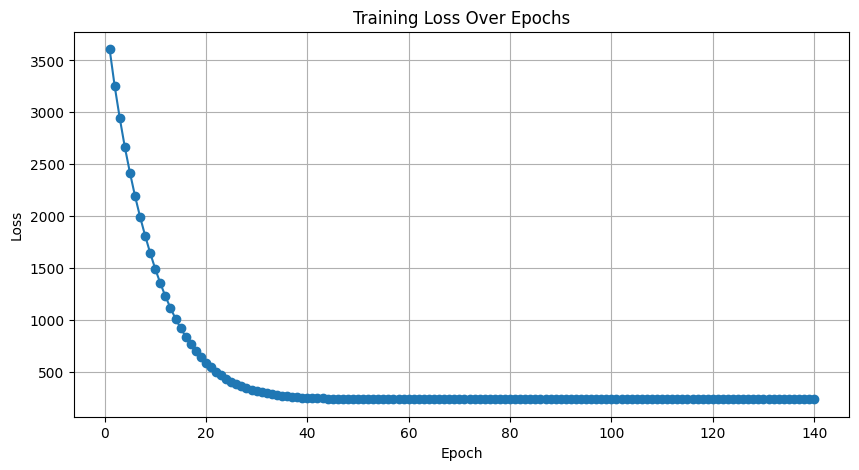

Model saved to /content/drive/MyDrive/MIDI4STRINGS_but_better/THE_PATH_OF_ALL_PATHS.pth


In [39]:
model_save_path = '/content/drive/MyDrive/MIDI4STRINGS_but_better/THE_PATH_OF_ALL_PATHS.pth'

run_workflow(midi_files, mp3_files, model_save_path, num_epochs=14, learning_rate=0.001, graph=True)

In [25]:
model_save_path = '/content/drive/MyDrive/MIDI4STRINGS_but_better/THE_PATH_OF_ALL_PATHS.pth'

model = load_model(model_save_path, input_size=128, hidden_size=128, output_size=N_MELS, num_layers=2)
generate_mp3_from_midi(model, '/content/drive/MyDrive/MIDI4STRINGS_but_better/Training Data/WebScrape/MIDI/Fur_Elise.mid', '/content/drive/MyDrive/MIDI4STRINGS_but_better/temp.mp3')


from IPython.display import Audio
Audio('/content/drive/MyDrive/MIDI4STRINGS_but_better/temp.mp3')

MP3 generated and saved to /content/drive/MyDrive/MIDI4STRINGS_but_better/temp.mp3


In [ ]:
# # Example Usage
# midi_files = ['path_to_midi_1.mid', 'path_to_midi_2.mid']
# mp3_files = ['path_to_mp3_1.mp3', 'path_to_mp3_2.mp3']
# model_save_path = 'trained_gru_synthesizer.pth'

# # Run the full workflow
# run_workflow(midi_files, mp3_files, model_save_path, num_epochs=10, learning_rate=0.001, graph=True)

# # Load the trained model and generate MP3 from MIDI
# model = load_model(model_save_path, input_size=128, hidden_size=128, output_size=N_MELS, num_layers=2)
# generate_mp3_from_midi(model, 'path_to_midi_1.mid', 'output_mp3_1.wav')